In [27]:
import numpy as np
import pandas as pd
from glob import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow as tf

train = pd.read_csv("../../scene-classification/train.csv")

In [28]:
from keras.preprocessing import image

train_image = []
for i in range(train.shape[0]):
#     print(train['image_name'][i])
    img = image.load_img('../../scene-classification/train/'+train['image_name'][i], target_size=(150,150,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)



In [29]:
from keras.utils import to_categorical
y=train['label'].values
y = to_categorical(y)

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# print shape of training set
print('x_train shape:', x_train.shape)
# print number of training, validation, and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

x_train shape: (10901, 150, 150, 3)
10901 train samples
3407 test samples
2726 validation samples


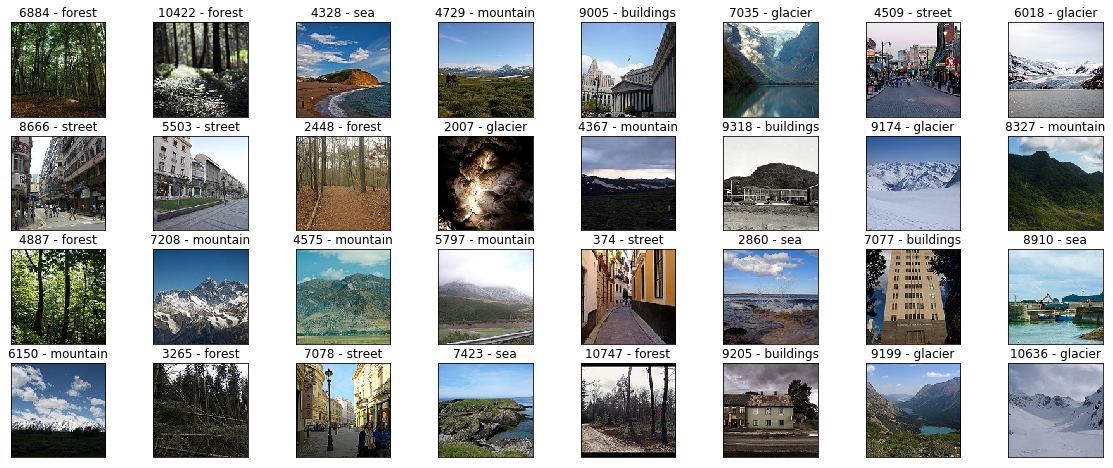

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

classification_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_train.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[idx]))
    label_idx = np.argmax(y_train[idx])
    ax.set_title("{} - {}".format(idx, classification_labels[label_idx]))

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 32)        2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               21904500  
__________

In [33]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model

In [34]:
from keras.callbacks import ModelCheckpoint   

# train the model
# checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_valid, y_valid), verbose=1, shuffle=True)


Train on 10901 samples, validate on 2726 samples
Epoch 1/10
10901/10901 [==============================] - 18s 2ms/step - loss: 2.0098 - acc: 0.5846 - val_loss: 0.8405 - val_acc: 0.6922
Epoch 2/10
10901/10901 [==============================] - 17s 2ms/step - loss: 0.6643 - acc: 0.7668 - val_loss: 0.6610 - val_acc: 0.7667
Epoch 3/10
10901/10901 [==============================] - 17s 2ms/step - loss: 0.4473 - acc: 0.8436 - val_loss: 0.6976 - val_acc: 0.7865
Epoch 4/10
10901/10901 [==============================] - 17s 2ms/step - loss: 0.2801 - acc: 0.9064 - val_loss: 0.7871 - val_acc: 0.7550
Epoch 5/10
10901/10901 [==============================] - 17s 2ms/step - loss: 0.1862 - acc: 0.9382 - val_loss: 0.8940 - val_acc: 0.7729
Epoch 6/10
10901/10901 [==============================] - 17s 2ms/step - loss: 0.1316 - acc: 0.9613 - val_loss: 0.9864 - val_acc: 0.7836
Epoch 7/10
10901/10901 [==============================] - 17s 2ms/step - loss: 0.1034 - acc: 0.9703 - val_loss: 1.1103 - val_acc:

### Load the Model with the Best Validation Accuracy

In [35]:
# load the weights that yielded the best validation accuracy
# model.load_weights('model.weights.best.hdf5')
model.save("../../model_weights/BenchmarkModel.h5")

### Calculate Classification Accuracy on Test Set

In [36]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.7660698562134456


In [37]:
# get predictions on the test set
y_hat = model.predict(x_test)

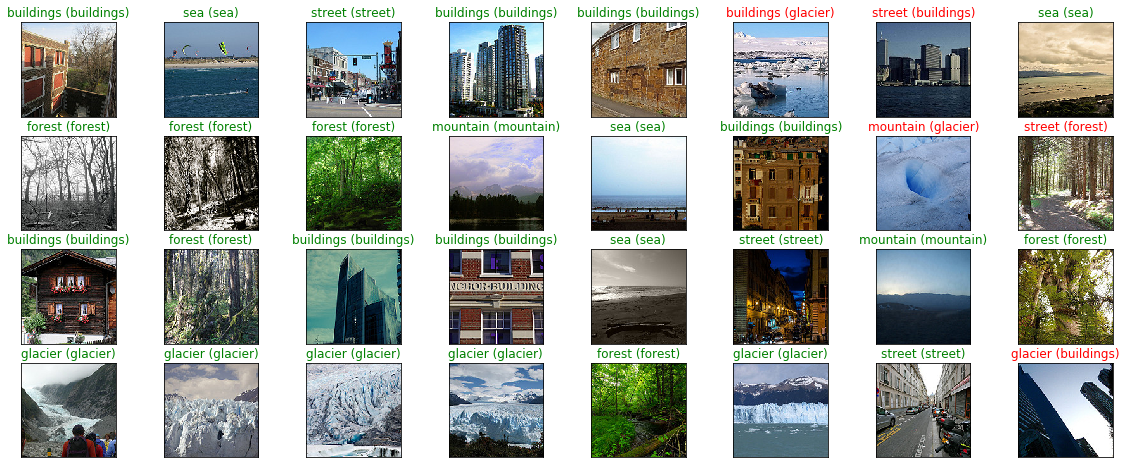

In [38]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(classification_labels[pred_idx], classification_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

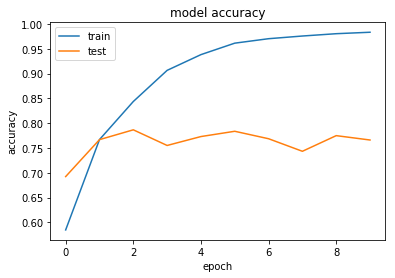

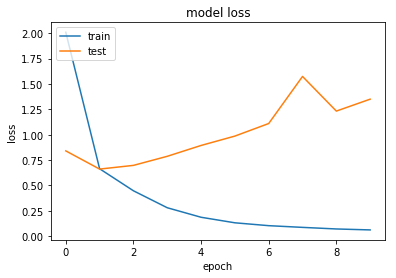

In [39]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()